### Description

In [1]:
### This code ingests a df of cleaned output and input variables and runs code to decide
### which calibration of Elastic Net vs. amended fused lasso works best.

### Imports

In [6]:
import pandas as pd

import numpy as np
from datetime import datetime
import xlsxwriter
import string
import os
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from sklearn.neighbors import KernelDensity
import seaborn as sns
import cvxpy as cp

## Specify parameters [1]

In [228]:
window_range = range(3,30)
shift_range = range(1,14)
alph_high_range = [0.6,0.7,0.8,0.9,0.95]
alph_low_range = [0.1,0.2,0.3,0.4,0.5]
x_variables = ['rolling_avg_pct_change']
y_variables = ['forward_opportunity_pct_sign']
dep_var = ['forward_21_opportunity_pct_size']
dep_var_type = "sign"
### Specify what indicators to use
### These variables should be iterable based on either a shift or a rolling window.It may be iterable multiple times

    
file_path = r"C:\Users\hugo.lu\repos\repos_backup\Strategy-creation\cleaned_matrices\technical_indicator_clean.csv"
pricing_data_string = r"C:\Users\hugo.lu\repos\repos_backup\Strategy-creation\Raw data\EURUSD\2020-05-05_EURUSD_MIDPOINT_10 Y_1 day.csv"

## Specify data

In [229]:
data_in = pd.read_csv(filepath_or_buffer = file_path, index_col = 0)

In [230]:
pricing_data = pd.read_csv(filepath_or_buffer = pricing_data_string, index_col = 0)

In [231]:
failure_list = []
for item in list(data_in.columns):
    try:
        data_in[item] = data_in[item].astype("float64")
    except:
        failure_list.append(item)

In [232]:
if  len(failure_list) == 0:
    print("Cast succeeded")
else:
    print("failed items: " + str(len(failure_list)))

Cast succeeded


In [233]:
failure_list = []
for item in list(data_in.columns):
    try:
        data_in[item] = data_in[item].astype("float64")
    except:
        failure_list.append(item)

In [234]:
if  len(failure_list) == 0:
    print("Cast succeeded")
else:
    print("failed items: " + str(len(failure_list)))

Cast succeeded


### Parameters

## Clean pricing data

In [235]:
data_columns = list(pricing_data.columns)
pricing_data_copy = pricing_data.copy(deep = True)
pricing_data_copy = pricing_data_copy.rename( columns = {
    
    'date': 'date',
    'open':'price',
    #'Ticker':'ticker'
    
})
pricing_data_copy['ticker'] = "EURUSD"
## Cast all relevant objects to floats

float_list = ['price','close']

for item in float_list:
    pricing_data_copy[item] = pricing_data_copy[item].astype('float64')
    ## Cast all relevant objects to dates

float_list = ['date']
for item in float_list:
    pricing_data_copy[item] = pd.to_datetime(pricing_data_copy[item])

### Calculate properties of FD

In [20]:
first_difference = pricing_data_copy['price_dif']

In [21]:
first_difference = first_difference.dropna()

In [22]:
first_difference.reset_index(inplace = True, drop = True)

In [23]:
## 1. Calculate mean and variance

In [24]:
mean = first_difference.mean()
std = first_difference.std()
skew = first_difference.skew()
kurtosis = first_difference.kurtosis()

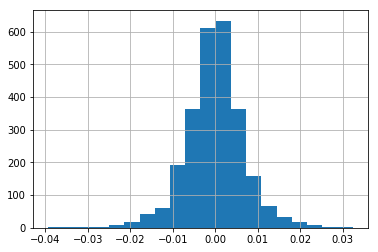

In [25]:
first_difference.hist(bins = 20)

In [26]:
kurtosis

2.3516833675048634

In [27]:

# seed the random number generator

stat, p = shapiro(first_difference)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.973, p=0.000
Sample does not look Gaussian (reject H0)


In [28]:
### Test skewness and kurtosis
stats.jarque_bera(first_difference)


(601.9511740761698, 0.0)

In [29]:
### Instead let's try KDE

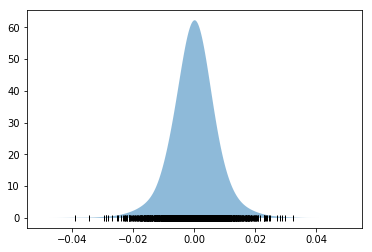

In [30]:
x_d = np.linspace(-0.05, 0.05, 1000)
x = np.array(first_difference)
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=0.003, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)


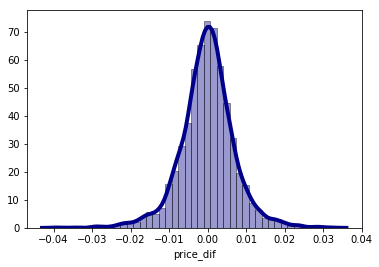

In [31]:
#Visualisation:
sns.distplot(first_difference, hist=True, kde=True, 
             bins=int(round((len(first_difference)/60))), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

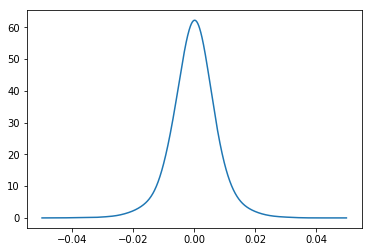

In [32]:

x = np.array(first_difference)
xs = np.linspace(-0.05,0.05,1000)
# expects n x p matrix with p features
x.shape = (len(x), 1)
xs.shape = (len(xs), 1)
#### Question@ is this the correct KDE to use? Probably can be refined and generalised....
kde = KernelDensity(bandwidth=0.003).fit(x)
dens = np.exp(kde.score_samples(xs))
plt.plot(xs, dens)
pass

In [33]:
probs = dens / sum(dens)
xs_comma = np.reshape(xs,newshape = (len(xs),))

In [34]:
mc = np.random.choice(xs_comma, size=10000, replace=True, p=probs)

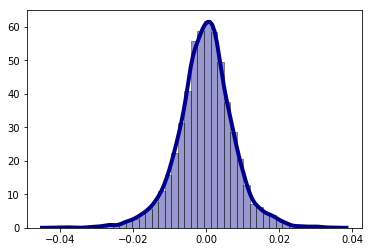

In [35]:
#Visualisation:
sns.distplot(mc, hist=True, kde=True, 
             bins=int(round((len(first_difference)/60))), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [36]:
new_df = pd.DataFrame(mc)
###########

In [37]:
new_df.mean()#####

0   -0.00014
dtype: float64

In [38]:
new_df.iloc[0] = 0#
new_df['price'] = 0##
new_df['price'].iloc[0] = 1#
new_df['price_calc'] = new_df['price'].cumsum() + new_df[0].cumsum()#

C:\Users\hugo.lu\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


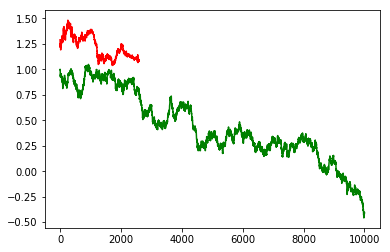

In [39]:
plt.plot(new_df['price_calc'],c="g")
plt.plot(pricing_data_copy['price'],c="r")

### Calculate indicators

In [260]:
## Form of function = "calc_"+ indicator name in x / y variables.
def self_reference(f):
    f.__defaults__ = f.__defaults__[:-1] + (f,)
    return f

@self_reference
def calc_momentum(df,price,window,self=None):
    df['last_%s_momentum' % window] = (df[price] / df[price].shift(window))-1
    string = 'last_%s_momentum' % window
    return df,string

@self_reference
def calc_rolling_avg_pct_change(df,price,window,shift,self=None):
    string = "rolling_"+str(window)+"_avg_"+str(shift)+"_period_pct_change"
    df[string] = df[price].rolling(window).mean()
    df[string] = (df[string]/df[string].shift(shift))-1
    
    return df,string

@self_reference
def calc_rolling_avg(df,price,window,self=None):
    df['rolling_%s_avg_price' % window] = df[price].rolling(window).mean()
    string = 'rolling_%s_avg_price' % window
    return df,string
 
@self_reference    
def calc_rolling_avg_price_dif(df,price,window,self=None):
    df['rolling_%s_avg_price_dif' % window] = df[price] - df[price].rolling(window).mean()
    string = 'rolling_%s_avg_price_dif' % window
    return df,string

@self_reference
def calc_RSI(df,price,window,self=None):
    random = df.copy(deep = True)
    random['status'] = random[price] - random[price].shift(1)
    random['status'] = random['status'].apply(lambda x: "Up" if x > 0 else "Down")
    random['average_for_up'] = random['status'].apply(lambda x: 1 if x == "Up" else 0)
    random['average_for_down'] = random['status'].apply(lambda x: 0 if x == "Up" else 1)
    random['average_price_up'] = (random['price']-random['price'].shift(1)) * random['average_for_up']
    random['average_price_down'] = (random['price']-random['price'].shift(1))* random['average_for_down']*-1
    random['average_price_up'] = random['average_price_up'].apply(lambda x: None if x ==  0 else x )
    random['average_price_down'] = random['average_price_down'].apply(lambda x: None if x == 0 else x )
    random['last_%s_RSI' % window] = random['average_price_up'].rolling(window, min_periods =1).sum() / random['average_price_down'].rolling(window, min_periods =1).sum()
    df['last_%s_RSI' % window] = 1 - 1/(1+random['last_%s_RSI' % window])
    for item in range(0,window): ## Formula above will not give NANs for the first (window-1) terms as min_periods = 1.
        df.at[item,'last_%s_RSI' % window] = None
    output_string = "last_" + str(window)+"_RSI"
    
    return df,output_string

@self_reference
def calc_forward_opportunity(df,price,window,self=None):
    df['forward_%s_opportunity' % window] = df[price].rolling(window).max()
    df['forward_%s_opportunity' % window] = df['forward_%s_opportunity' % window].shift(-window) - df[price]
    string = 'forward_%s_opportunity' % window
    return df,string 

@self_reference
def calc_forward_opportunity_pct_sign(df,price,window,self=None):
    df['forward_%s_opportunity_pct_sign' % window] = df[price].rolling(window).max()
    df['forward_%s_opportunity_pct_sign' % window] = (df['forward_%s_opportunity_pct_sign' % window].shift(-window) - df[price])/df[price]
    df['forward_%s_opportunity_pct_sign' % window] = df['forward_%s_opportunity_pct_sign' % window].apply(lambda x: 0 if x<0 else 1)
    string = 'forward_%s_opportunity_pct_sign' % window
    return df,string 

@self_reference
def calc_forward_opportunity_pct_size(df,price,window,self=None):
    df['forward_%s_opportunity_pct_size' % window] = df[price].rolling(window).max()
    df['forward_%s_opportunity_pct_size' % window] = (df['forward_%s_opportunity_pct_size' % window].shift(-window) - df[price])/df[price]
    df['forward_%s_opportunity_pct_size' % window] = df['forward_%s_opportunity_pct_size' % window].apply(lambda x: -x if x<0 else x)
    string = 'forward_%s_opportunity_pct_size' % window
    return df,string 


### specify function list; must be ordered:
@self_reference
def calc_ema(df,price,alph,self = None):
    df['last_%s_EMA' % window ] = df[price].ewm(alpha=alph).mean()
    string = 'last_%s_EMA' % window 
    return df,string

@self_reference
def calc_ema_cross(df,price,alph_high,alph_low,self = None):
    rider = df.copy(deep = True)
    rider['high'] =  rider[price].ewm(alpha=alph_high).mean()
    rider['low'] = rider[price].ewm(alpha = alph_low).mean()
    rider['dif'] = rider['high'] - rider['low']
    rider['dif'] = rider['dif'].apply(lambda x: 1 if x>0 else 0)
    rider['dif_lag'] = rider['dif'].shift(1)
    rider['dif_lag'] = rider['dif_lag'].apply(lambda x: 1 if x>0 else 0)
    rider['signal'] = rider['dif'] - rider['dif_lag']
    
    
    string = str(alph_high) + "_high_" + str(alph_low) + "_low_ema_cross"
    df[string] = rider['signal']
    return df,string

@self_reference
def calc_ema_diff(df,price,alph_high,alph_low,self = None):
    rider = df.copy(deep = True)
    rider['high'] =  rider[price].ewm(alpha=alph_high).mean()
    rider['low'] = rider[price].ewm(alpha = alph_low).mean()
    rider['dif'] = rider['high'] - rider['low']
    #print("xx")
    
    string = str(alph_high) + "_high_" + str(alph_low) + "_low_ema_dif"
    df[string] = rider['dif']
    return df,string


calc_momentum.type = "window"
calc_rolling_avg_pct_change.type = "window_shift"
calc_rolling_avg.type = "window"
calc_rolling_avg_price_dif.type = "window"
calc_RSI.type="window"
calc_forward_opportunity.type = "window"
calc_ema.type = "window"
calc_ema_cross.type = "alpha"
calc_ema_diff.type = "alpha"
calc_forward_opportunity_pct_size.type = "window"
calc_forward_opportunity_pct_sign.type = "window"


In [261]:
### Specify what indicators to use

all_variables = x_variables + y_variables
x_dic = {}
for item in x_variables:
    x_dic[item] = eval("calc_"+str(item))
    
y_dic = {}
for item in y_variables:
    y_dic[item] = eval("calc_"+str(item))

In [254]:
for a,b in y_dic.items():
    print(a)
    print(b)

forward_opportunity_pct_sign
<function calc_forward_opportunity_pct_sign at 0x00000237802FA488>


In [255]:
def calc_indicators(new_df,x_dic,y_dic,window_range,shift_range,alph_high_range,alph_low_range):
    
    x_variables_actual = []
    y_variables_actual = []
    print("Calculating x variables")
    for key,value in x_dic.items():
        #print("calculating indicators for: " + str(key))
        if value.type == "window":
            for item in window_range:

                [new_df,b] = value(new_df,'price',item)
                x_variables_actual.append(b)
        elif value.type == "window_shift":
            for item in window_range:
                for jtem in shift_range:
                    [new_df,b] = value(new_df,'price',item,jtem)
                    x_variables_actual.append(b)
        elif value.type == "alpha":
                for a in alph_high_range:
                    for c in alph_low_range:
                        [new_df,b] = value(new_df,'price',a,c)
                        x_variables_actual.append(b)
        else:
            print("Functions specified incorrectly")
            break

    print("Calculating y variables")
    for key,value in y_dic.items():
        #print("calculating indicators for: " + str(key))
        if value.type == "window":
            for item in window_range:

                [new_df,b] = value(new_df,'price',item)
                y_variables_actual.append(b)
        elif value.type == "window_shift":
            for jtem in shift_range:
                for item in window_range:
                    [new_df,b] = value(new_df,'price',item,jtem)
                    y_variables_actual.append(b)
        else:
            print("Functions specified incorrectly")
            break
    return new_df,x_variables_actual,y_variables_actual

In [240]:
def normalise_data(df,var_list):
    rider = df.copy(deep = True)
    data_mean = list(rider.mean())
    data_std = list(rider.std())
    rider = (rider - data_mean)/data_std
    rider = rider[var_list]
    df.loc[:,var_list] = rider.loc[:,var_list]
    return df

In [241]:
def delete_non_stationary_variables(df,x_variables_actual,y_variables_actual):
    stationary_vars = []
    
    for item in list(df.columns):
        if item == 'price':
            print("Skip")
        else:
            X = df[item].dropna()
            result = adfuller(X)
            #print('ADF Statistic: %f' % result[0])
            #print('p-value: %f' % result[1])
            #print('Critical Values:')
            #for key, value in result[4].items():
            #    print('\t%s: %.3f' % (key, value))
            if result[0] < -3.434:
                #print("Stationary for: " + str(item))
                stationary_vars.append(item)
            else:
                print("Non stationary for: " + str(item))
                try:
                    x_variables_actual.remove(item)
                except:
                    y_variables_actual.remove(item)
    return df[stationary_vars],x_variables_actual,y_variables_actual

In [242]:
### Lasso

def loss_fn_lasso(X, Y, beta):
    return cp.norm2(X @ beta - Y)**2

def regularizer_lasso(beta):
    return cp.norm1(beta)

def objective_fn_lasso(X, Y, beta, lambd):
    return loss_fn_lasso(X, Y, beta) + lambd * regularizer_lasso(beta)

def mse_lasso(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn_lasso(X, Y, beta).value

## Ridge

def loss_fn_ridge(X, Y, beta):
    return cp.pnorm(X @ beta - Y, p=2)**2

def regularizer_ridge(beta):
    return cp.pnorm(beta, p=2)**2

def objective_fn_ridge(X, Y, beta, lambd):
    return loss_fn_ridge(X, Y, beta) + lambd * regularizer_ridge(beta)

def mse_ridge(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn_ridge(X, Y, beta).value


## Elastic net

def loss_fn_elastic_net(X, Y, beta):
    return cp.pnorm(Y - X @ beta , p=2)**2

def regularizer_elastic_net(beta,lambd,lambd2):
    return (lambd2)*cp.pnorm(beta, p=2)**2 + (lambd)*cp.norm1(beta) 


def objective_fn_elastic_net(X, Y, beta, lambd,lambd2):
    return loss_fn_elastic_net(X, Y, beta) + regularizer_elastic_net(beta,lambd,lambd2)

def mse_elastic_net(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn_elastic_net(X, Y, beta).value





In [243]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()


In [244]:
def conduct_lasso(data_copy,x_variables_actual,dep_var):
    x_variables_actual = list(set(x_variables_actual))
    
    regression_data = data_copy.copy(deep = True)
    regression_data = regression_data[x_variables_actual+dep_var]
    regression_data = regression_data.dropna()
    regression_data = (regression_data-regression_data.mean())/regression_data.std()

    m = len(regression_data)
    n = len(x_variables_actual)
    alpha = 0 ##Nests Lasso
    X = np.array(regression_data[x_variables_actual])
    if dep_var_type == "sign":
        Y = np.array(regression_data[dep_var].iloc[:,0].apply(lambda x: 1 if x > 0 else 0))
    else:    
        Y = np.array(regression_data[dep_var].iloc[:,0].apply(lambda x: -x if x<0 else x))
        Y = (Y - Y.mean())/Y.std()
    X_train = X[:int(m/2),:]
    Y_train = Y[:int(m/2)]
    X_test = X[int(m/2):,:]
    Y_test = Y[int(m/2):]

    beta = cp.Variable(n)
    lambd = cp.Parameter(nonneg=True)
    lambd2 = cp.Parameter(nonneg=True)
    print("a")
    problem = cp.Problem(cp.Minimize(objective_fn_elastic_net(X_train, Y_train, beta, lambd,lambd2)))
    print("b")
    lambd_values = np.logspace(-2, 3, 50) ## Changing the lambda is equivalent to changing the t in order to observe different levels of regularisation
    ## alpha = l2/(l1+l2)
    ## so l2 = l1*alpha/(1-alpha)
    lambd2_values = lambd_values*(alpha/(1-alpha))

    train_errors = []
    test_errors = []
    beta_values = []
    counter = 0
    print("c")
    for count,v in enumerate(lambd_values):
        lambd.value = v
        lambd2.value = lambd2_values[count]
        print("Values remaining: " +str(len(lambd_values)-count))
        problem.solve()
        test_error = mse_elastic_net(X_test, Y_test, beta)
        train_errors.append(mse_elastic_net(X_train, Y_train, beta))
        test_errors.append(test_error)
        beta_values.append(beta.value)
        


    opt_lambda = lambd_values[test_errors.index(min(test_errors))]
    opt_beta = beta_values[test_errors.index(min(test_errors))]
    y_pred = X_test@opt_beta
    avg_ss = sum(((Y_test - Y_test.mean())**2)**(0.5))
    pred_ss = sum(((Y_test - y_pred)**2)**(0.5))
    r_squared = 1- (pred_ss/avg_ss)
    plot_train_test_errors(train_errors, test_errors, lambd_values)
    plot_regularization_path(lambd_values, beta_values)
    return r_squared,opt_lambda,opt_beta

In [245]:


def perform_mc_kde(x_values,probs,size,iterations):
    output_params = pd.DataFrame(index= range(0,iterations))
    output_values = pd.DataFrame()
    output_params['mean'] = None
    output_params['std'] = None
    output_params['skew'] = None
    output_params['kurtosis'] = None

    for i in range(0,iterations):
        mc = np.random.choice(x_values, size=size, replace=True, p=probs)
        new_df = pd.DataFrame(mc)
        ## Calculate params
        mean = new_df[0].mean()
        std = new_df[0].std()
        skew = new_df[0].skew()
        kurtosis = new_df[0].kurtosis()
        output_params.at[i,'mean'] = mean
        output_params.at[i,'std'] = std
        output_params.at[i,'skew'] = skew
        output_params.at[i,'kurtosis'] = kurtosis
        ## Calculate values
        new_df.iloc[0] = 0
        new_df['price'] = 0
        new_df['price'].iloc[0] = 1
        new_df['price_calc'] = new_df['price'].cumsum() + new_df[0].cumsum()
        output_values['price'] = new_df['price_calc']
        print("Completed simulation: " + str(i))
    
    return output_params,output_values

In [262]:
[a,b]=perform_mc_kde(xs_comma,probs,3000,1)

Completed simulation: 0


In [263]:
b_copy = b.copy(deep = True)

In [264]:
[out,x_var_list,y_var_list] = calc_indicators(b_copy
                                              ,x_dic,y_dic,window_range,shift_range,alph_high_range,alph_low_range)

Calculating x variables
Calculating y variables


In [265]:
y_var_list

['forward_3_opportunity_pct_sign',
 'forward_4_opportunity_pct_sign',
 'forward_5_opportunity_pct_sign',
 'forward_6_opportunity_pct_sign',
 'forward_7_opportunity_pct_sign',
 'forward_8_opportunity_pct_sign',
 'forward_9_opportunity_pct_sign',
 'forward_10_opportunity_pct_sign',
 'forward_11_opportunity_pct_sign',
 'forward_12_opportunity_pct_sign',
 'forward_13_opportunity_pct_sign',
 'forward_14_opportunity_pct_sign',
 'forward_15_opportunity_pct_sign',
 'forward_16_opportunity_pct_sign',
 'forward_17_opportunity_pct_sign',
 'forward_18_opportunity_pct_sign',
 'forward_19_opportunity_pct_sign',
 'forward_20_opportunity_pct_sign',
 'forward_21_opportunity_pct_sign',
 'forward_22_opportunity_pct_sign',
 'forward_23_opportunity_pct_sign',
 'forward_24_opportunity_pct_sign',
 'forward_25_opportunity_pct_sign',
 'forward_26_opportunity_pct_sign',
 'forward_27_opportunity_pct_sign',
 'forward_28_opportunity_pct_sign',
 'forward_29_opportunity_pct_sign']

In [266]:
## Use this to decide whether or not the KDE has yielded good results. To be honest, the kurtosis and skew differences
## do not look great. Let's press on in any case.

In [267]:
out.head(5)

,price,rolling_3_avg_1_period_pct_change,rolling_3_avg_2_period_pct_change,rolling_3_avg_3_period_pct_change,rolling_3_avg_4_period_pct_change,rolling_3_avg_5_period_pct_change,rolling_3_avg_6_period_pct_change,rolling_3_avg_7_period_pct_change,rolling_3_avg_8_period_pct_change,rolling_3_avg_9_period_pct_change,...,forward_20_opportunity_pct_sign,forward_21_opportunity_pct_sign,forward_22_opportunity_pct_sign,forward_23_opportunity_pct_sign,forward_24_opportunity_pct_sign,forward_25_opportunity_pct_sign,forward_26_opportunity_pct_sign,forward_27_opportunity_pct_sign,forward_28_opportunity_pct_sign,forward_29_opportunity_pct_sign
0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
1,0.995045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
2,1.011411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
3,0.993844,-0.002048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
4,0.996597,0.000517,-0.001532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1


In [268]:
# Filter variables
out = out[x_var_list+y_var_list]

In [269]:
out.head(5)

,rolling_3_avg_1_period_pct_change,rolling_3_avg_2_period_pct_change,rolling_3_avg_3_period_pct_change,rolling_3_avg_4_period_pct_change,rolling_3_avg_5_period_pct_change,rolling_3_avg_6_period_pct_change,rolling_3_avg_7_period_pct_change,rolling_3_avg_8_period_pct_change,rolling_3_avg_9_period_pct_change,rolling_3_avg_10_period_pct_change,...,forward_20_opportunity_pct_sign,forward_21_opportunity_pct_sign,forward_22_opportunity_pct_sign,forward_23_opportunity_pct_sign,forward_24_opportunity_pct_sign,forward_25_opportunity_pct_sign,forward_26_opportunity_pct_sign,forward_27_opportunity_pct_sign,forward_28_opportunity_pct_sign,forward_29_opportunity_pct_sign
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
3,-0.002048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
4,0.000517,-0.001532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1


In [270]:
#out = normalise_data(out,x_var_list+y_var_list)

In [271]:
[out,x_var_list,y_var_list] = delete_non_stationary_variables(out,x_var_list,y_var_list)

In [163]:
## Perform feature selection
def calc_covariance_matrix(df,x_var_list):
    df = df[x_var_list]
    df = df.dropna()
    df.reset_index(inplace = True, drop = True)
    
    
    df = df - df.mean()
    df = np.array(df)
    cov = df.T.dot(df)
    return cov
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std=np.sqrt(np.diag(cov))
    corr=cov/np.outer(std,std)
    corr[corr<-1],corr[corr>1]=-1,1 # numerical error
    return corr

def perform_feature_selection(df): ## performs feature selection on a set of variables. Cannot contain NaNs
    if df != df.dropna():
        return "Not correctly specified"
    else:
        return
        

In [164]:
covariance = calc_covariance_matrix(out,x_var_list)

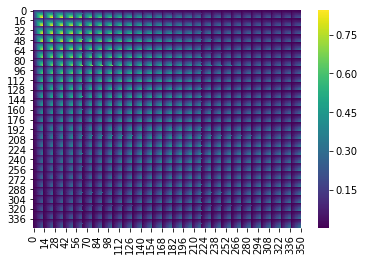

In [165]:
sns.heatmap(pd.DataFrame(covariance), cmap = "viridis")

In [166]:
correlation = cov2corr(covariance)

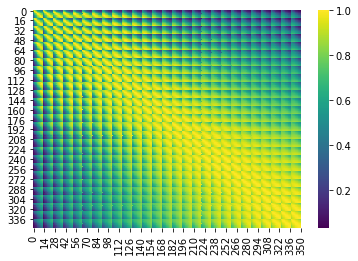

In [167]:
sns.heatmap(pd.DataFrame(correlation), cmap = "viridis")

In [168]:
### We need to minimise the number of features by maximising the covariance while minimising the number of variables
### and the correlation

In [169]:
total_variance = np.trace(covariance)

### Lasso

In [276]:
out_copy = out.copy(deep = True
                   )

sign
a
b
c
Values remaining: 10
Values remaining: 9
Values remaining: 8
Values remaining: 7
Values remaining: 6
Values remaining: 5
Values remaining: 4
Values remaining: 3
Values remaining: 2
Values remaining: 1


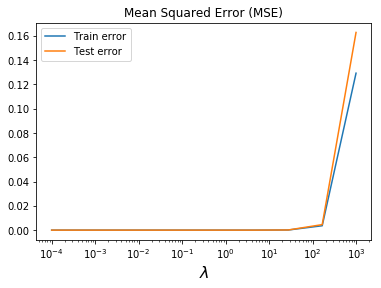

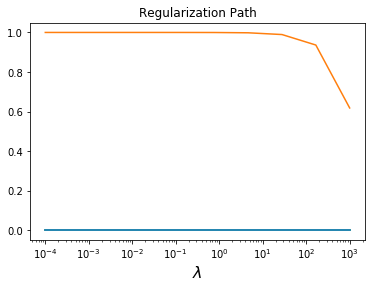

In [311]:
dep_var = 'forward_21_opportunity_pct_sign'
print(dep_var_type) 
x_variables_actual = []
x_variables_actual = list(set(x_var_list))
all_list = []
all_list = x_variables_actual.copy()
all_list.append(dep_var)
regression_data = out_copy.copy(deep = True)
regression_data = regression_data[all_list]
regression_data = regression_data.dropna()
regression_data = (regression_data-regression_data.mean())/regression_data.std()
regression_data.reset_index(drop = True, inplace = True)

m = len(regression_data)
n = len(x_variables_actual)
alpha = 0 ##Nests Lasso
X = np.array(regression_data.loc[:,x_variables_actual])

Y = np.array(regression_data.loc[:,dep_var])
Y = (Y - Y.mean())/Y.std()
X_train = X[:int(m/2),:]
Y_train = Y[:int(m/2)]
X_test = X[int(m/2):,:]
Y_test = Y[int(m/2):]

beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
lambd2 = cp.Parameter(nonneg=True)
print("a")
problem = cp.Problem(cp.Minimize(objective_fn_elastic_net(X_train, Y_train, beta, lambd,lambd2)))
print("b")
lambd_values = np.logspace(-4, 3, 10) ## Changing the lambda is equivalent to changing the t in order to observe different levels of regularisation
## alpha = l2/(l1+l2)
## so l2 = l1*alpha/(1-alpha)
lambd2_values = lambd_values*(alpha/(1-alpha))

train_errors = []
test_errors = []
beta_values = []
counter = 0
print("c")
for count,v in enumerate(lambd_values):
    lambd.value = v
    lambd2.value = lambd2_values[count]
    print("Values remaining: " +str(len(lambd_values)-count))
    problem.solve()
    test_error = mse_elastic_net(X_test, Y_test, beta)
    train_errors.append(mse_elastic_net(X_train, Y_train, beta))
    test_errors.append(test_error)
    beta_values.append(beta.value)



opt_lambda = lambd_values[test_errors.index(min(test_errors))]
opt_beta = beta_values[test_errors.index(min(test_errors))]
y_pred = X_test@opt_beta
avg_ss = sum(((Y_test - Y_test.mean())**2)**(0.5))
pred_ss = sum(((Y_test - y_pred)**2)**(0.5))
r_squared = 1- (pred_ss/avg_ss)
plot_train_test_errors(train_errors, test_errors, lambd_values)
plot_regularization_path(lambd_values, beta_values)


In [315]:
dep_var = 'forward_21_opportunity_pct_sign'
print(dep_var_type) 
x_variables_actual = []
x_variables_actual = list(set(x_var_list))
all_list = []
all_list = x_variables_actual.copy()
all_list.append(dep_var)

sign


In [320]:
regression_data = out_copy.copy(deep = True)
regression_data = regression_data[all_list]
regression_data = regression_data.dropna()
regression_data = (regression_data-regression_data.mean())/regression_data.std()
regression_data.reset_index(drop = True, inplace = True)

m = len(regression_data)
n = len(x_variables_actual)
alpha = 0 ##Nests Lasso
X = np.array(regression_data.loc[:,x_variables_actual])

Y = np.array(regression_data.loc[:,dep_var])
Y = (Y - Y.mean())/Y.std()
X_train = X[:int(m/2),:]
Y_train = Y[:int(m/2)]
X_test = X[int(m/2):,:]
Y_test = Y[int(m/2):]

In [323]:
len(X)

2959

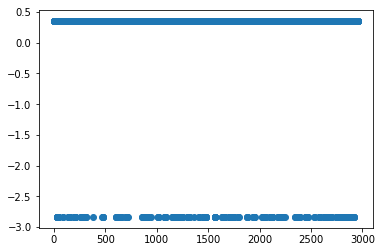

In [294]:
plt.scatter(range(0,len(Y)),Y)

In [305]:
x_variables_actual = list(set(x_var_list))

In [313]:
random = x_variables_actual.copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000237E480AF98>]],
      dtype=object)

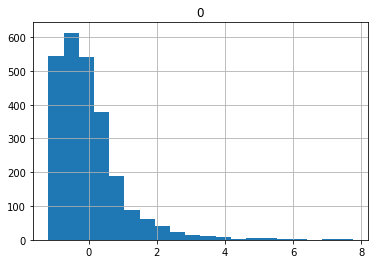

In [135]:
pd.DataFrame(Y).hist(bins = 20)

In [301]:
regression_data.loc[:,x_variables_actual]

,rolling_25_avg_6_period_pct_change,rolling_25_avg_3_period_pct_change,rolling_8_avg_6_period_pct_change,rolling_21_avg_10_period_pct_change,rolling_10_avg_11_period_pct_change,rolling_19_avg_3_period_pct_change,rolling_19_avg_10_period_pct_change,rolling_4_avg_1_period_pct_change,rolling_13_avg_7_period_pct_change,rolling_15_avg_5_period_pct_change,...,rolling_23_avg_13_period_pct_change,rolling_22_avg_5_period_pct_change,rolling_7_avg_11_period_pct_change,rolling_11_avg_4_period_pct_change,rolling_11_avg_10_period_pct_change,rolling_14_avg_7_period_pct_change,rolling_24_avg_2_period_pct_change,rolling_25_avg_12_period_pct_change,rolling_5_avg_13_period_pct_change,forward_21_opportunity_pct_sign
0,1.241097,1.201782,0.942819,1.153003,1.140091,1.110178,1.091175,0.284662,0.984372,0.871807,...,1.340083,0.798091,1.060837,0.969932,1.140228,1.018438,0.950508,1.476707,0.808418,0.352418
1,1.117425,0.920688,0.656093,1.107499,1.091817,0.918899,1.032396,0.203457,0.811460,0.757662,...,1.284701,0.737139,0.881420,0.921414,1.092015,0.825305,0.609553,1.426010,0.801344,0.352418
2,0.982984,0.709383,0.324002,1.086862,1.051711,0.765266,0.976687,-0.168576,0.851251,0.781217,...,1.269146,0.771413,0.905450,0.852608,1.052044,0.794100,0.419533,1.372100,0.974523,0.352418
3,0.875920,0.520690,0.194567,0.969220,0.941899,0.529816,0.847820,-0.427408,0.817105,0.774925,...,1.227782,0.783134,0.798492,0.655439,0.940482,0.819815,0.647682,1.282735,0.819945,0.352418
4,0.744891,0.545014,-0.008703,0.809567,0.675448,0.592522,0.761146,-0.630256,0.824115,0.771426,...,1.159788,0.718034,0.587760,0.155674,0.674661,0.786403,0.755833,1.222232,0.648760,0.352418
5,0.720275,0.707994,-0.024715,0.764796,0.598772,0.671635,0.777774,0.982662,0.750510,0.702261,...,1.107690,0.790236,0.419998,0.000712,0.599196,0.814214,0.891625,1.123672,0.662788,0.352418
6,0.732384,0.920543,-0.130567,0.774420,0.506459,0.768783,0.789230,0.348896,0.554604,0.719818,...,1.018090,0.743437,0.282986,-0.047608,0.506991,0.712804,0.944113,1.025957,0.461384,0.352418
7,0.749069,0.928874,0.011318,0.791674,0.471201,0.818983,0.858237,0.283840,0.385008,0.708975,...,0.899326,0.754448,0.142144,-0.111888,0.472098,0.537265,0.718153,0.969964,0.170787,0.352418
8,0.826885,0.918123,0.273490,0.821718,0.497799,0.946000,0.880764,1.663363,0.393732,0.571528,...,0.905723,0.783522,0.249708,0.361952,0.498236,0.489738,0.743915,0.940382,0.220000,0.352418
9,0.877916,0.805417,0.419701,0.871583,0.403389,0.999469,0.848510,0.346162,0.331711,0.431302,...,0.872519,0.868175,0.229777,0.536611,0.403877,0.445035,0.987312,0.911034,0.294278,0.352418


NameError: name 'plot_train_test_errors' is not defined

## Conclusion

In [ ]:
## Using the KDE estimates to estimate the parameters is not a good technique. As conjectured by the ML literature,
## the backtesting does not provide an effective researching tool. However, the spirit of the simulations is
## correct; the main problem with overfitting backtests to trading rules, is that the rule is
## derived, subject to parameters e.g. take profit and stop loss limits. These are then calibrated to historical 
## data only which creates overfittingde PRado suggests we fit a price process
## to the historical data (parameters we want to keep) and then use these to estimate the take profit and stop loss
## pairs. So insofar we are using only the fundamental properties of the historical data they are acceptable as a backtest.


## There are a number of limiting factors that we need to address in v2:
## 1. Fractionally differentiate time series instead of taking FD
## 2. Actually use the historical data
## 3. See how the theorems function without regularisation

## Specify functions to define trading behaviours

In [ ]:
### This function invests the entire portfolio on a buy signal.
### If the portfolio is invested, it ignores all other buy signals
### If the portfolio hits a sell signal, it divests the entire portfolio
### It returns the data frame, as well as a dataframe with the columns;
### "Action","Amount","Price_executed"

def all_in_trading_behaviour(df,price,status):
    starting_capital = 1000
    amount_in_stock = 0
    buy_price = 0
    sell_price = 0 
    units = 0
    trade_number = 0
    output_list = []

    df['capital_status'] = df[status].apply(lambda x: None if x =="Hold" else x)
    df['capital_status'] = df['capital_status'].fillna(method = 'ffill') 
    df.loc[(df['capital_status'].isna()),'capital_status'] = None
    df['capital_invested'] = df['capital_status'].apply(lambda x: "free" if x == None else("invested"if x == "Buy" else "free"))
    df['capital_invested_previous'] = df['capital_invested'].shift(1)
    df['trade_made'] = "N"
    df['unit_balance'] = None
    df['unit_value'] = None
    for i in range(0,len(df)):
        if i == 0 :
            amount_in_stock = starting_capital
        else:
            row = df.iloc[i,:]
            #print(row)
            if row["capital_invested_previous"] == "free" and row["capital_status"] == None:
                #amount_in_stock = starting_capital
                df.at[i,'trade_made'] = "N"
                df.at[i,'unit_balance'] = units
                df.at[i,'unit_value'] = units*row['price']
                print("Nothing bought")
            elif row["capital_invested_previous"] == "free" and row["capital_status"] == "Buy":
                buy_price = row['price']
                units = amount_in_stock / (buy_price+pip_margin)
                trade_number +=1
                df.at[i,'trade_made'] = "Y"
                df.at[i,'unit_balance'] = units
                df.at[i,'unit_value'] = units*row['price']
                print("Units bought:" + str(units))
            elif row["capital_invested_previous"] == "invested" and row["capital_status"] == "Sell":
                sell_price = row['price']
                amount_in_stock = units*(sell_price-pip_margin)
                units = 0
                trade_number +=1
                df.at[i,'trade_made'] = "Y"
                df.at[i,'unit_balance'] = units
                df.at[i,'unit_value'] = amount_in_stock
                print("Units sold. Amount in stock: " + str(amount_in_stock))
            elif i == len(new_df)-1:
                sell_price = row['price']
                if units > 0:
                    amount_in_stock = units*(sell_price-pip_margin)
                    units = 0
                    trade_number +=1
                    df.at[i,'trade_made'] = "Y"
                    df.at[i,'unit_balance'] = units
                    df.at[i,'unit_value'] = amount_in_stock
                print("End")
    output_list.append([item,amount_in_stock,trade_number]) 
    
    return df,output_list,df[['trade_made','unit_balance','unit_value']]



In [ ]:
### This function invests a fraction of the portfolio on a buy signal.
### If the portfolio is invested, it ignores all other buy signals
### If the portfolio hits a sell signal, it divests the entire portfolio
### It returns the data frame, as well as a dataframe with the columns;
### "Action","Amount","Price_executed"
###  portfolio left = 1-(buy_num*frac)
### total_count = 1/frac
### total_count - buy_count = number left
### frac = 1/number_left


def fixed_proportion_trading_behaviour(df,price,status,date,buy_frac,sell_frac):
    starting_capital = 1000
    amount_in_stock = 0
    units = 0 
    trade_number = 0
    output_list = []
    net_buy_number = 0
    buy_num_exp = 1/buy_frac
    sell_num_exp = 1/ sell_frac
    
    
    #### You need an iterable and then you fill in the iterable onto the column
    
    df['capital_status_ffill'] = df[status].apply(lambda x: None if x =="Hold" else x)
    df['capital_status_ffill'] = df['capital_status_ffill'].fillna(method = 'ffill') 
    
    df['trade_made'] = "N"
    df['unit_balance'] = 0
    df['unit_value'] = 0
    df['amount_in_stock'] = 0
   
    for i in range(0,len(df)):
        row = df.iloc[i,:]
        if i == 0 : ## If at the start, set everything to zero
            amount_in_stock = starting_capital
            df.at[i,'trade_made'] = "N"
            units = 0
            df.at[i,'unit_balance'] = units
            df.at[i,'unit_value'] = units * row['price']
            df.at[i,'amount_in_stock'] = amount_in_stock
            
            
        else:
           
            
            if amount_in_stock > 0 and row[status] == "Buy": ### If there is a buy status
                print("Starting buy")
                df.at[i,'trade_made'] = "Y"
                
                units += (1/(buy_num_exp - net_buy_number))*amount_in_stock/(row['price'] + pip_margin)
                
                df.at[i,'unit_balance'] = units
                df.at[i,'unit_value'] = units * row['price']
                
                amount_in_stock -= (1/(buy_num_exp - net_buy_number))*amount_in_stock
                
                df.at[i,'amount_in_stock'] = amount_in_stock
             
                trade_number += 1
                net_buy_number += 1
                
            elif units > 0 and row[status] == "Sell": ### If there is a sell status
                print("Starting sell")
                df.at[i,'trade_made'] = "Y"
                
                amount_in_stock += (1/(net_buy_number))*units*(row['price'] - pip_margin) ## update outgoing (amount in stock) first
                df.at[i,'amount_in_stock'] = amount_in_stock ## units not updated yet
                
                units -= (1/(net_buy_number))*units ## decrease units
                
                df.at[i,'unit_balance'] = units ## update units
                
                df.at[i,'unit_value'] = units * row['price'] ## update unit values
             
                trade_number += 1
                net_buy_number -= 1
            elif i == len(new_df)-1:
                
                amount_in_stock += units*(row['price']-pip_margin)
                units = 0
                trade_number +=1
                net_buy_number -= 1
                df.at[i,'trade_made'] = "Y"
                df.at[i,'unit_balance'] = units
                df.at[i,'unit_value'] = units * row['price']
                df.at[i,'amount_in_stock'] = amount_in_stock
                print("End")
            else:
                df.at[i,'unit_balance'] = units
                df.at[i,'unit_value'] = units * row['price']
                df.at[i,'amount_in_stock'] = amount_in_stock
                
    output_list.append([item,amount_in_stock,trade_number,net_buy_number]) 
    returns_list = []
    
    first_date = df[df[status] == "Buy"][date].min()
    last_date = df[date].max()
    duration = (last_date - first_date).days
    returns = ((df['amount_in_stock'][len(df)-1] / starting_capital)**(1/duration))**365 - 1
    
    return df,output_list,returns


## Specify regression functions

## Specify regression performance functions

In [ ]:
def conduct_lasso(data_copy,dep_var):
    
    regression_data = data_copy.copy(deep = True)
    regression_data = regression_data[sub_all_var_list]
    regression_data = regression_data.dropna()

    m = len(regression_data)
    n = len(sub_x_variable_actual_list)
    alpha = 0 ##Nests Lasso
    X = np.array(regression_data[sub_x_variable_actual_list])
    Y = np.array(regression_data[dep_var])
    X_train = X[:int(m/2),:]
    Y_train = Y[:int(m/2)]
    X_test = X[int(m/2):,:]
    Y_test = Y[int(m/2):]

    beta = cp.Variable(n)
    lambd = cp.Parameter(nonneg=True)
    lambd2 = cp.Parameter(nonneg=True)
    problem = cp.Problem(cp.Minimize(objective_fn_elastic_net(X_train, Y_train, beta, lambd,lambd2)))
    lambd_values = np.logspace(-2, 3, 50) ## Changing the lambda is equivalent to changing the t in order to observe different levels of regularisation
    ## alpha = l2/(l1+l2)
    ## so l2 = l1*alpha/(1-alpha)
    lambd2_values = lambd_values*(alpha/(1-alpha))

    train_errors = []
    test_errors = []
    beta_values = []
    counter = 0
    for count,v in enumerate(lambd_values):
        lambd.value = v
        lambd2.value = lambd2_values[count]

        problem.solve()
        test_error = mse_elastic_net(X_test, Y_test, beta)
        train_errors.append(mse_elastic_net(X_train, Y_train, beta))
        test_errors.append(test_error)
        beta_values.append(beta.value)


    opt_lambda = lambd_values[test_errors.index(min(test_errors))]
    opt_beta = beta_values[test_errors.index(min(test_errors))]
    y_pred = X_test@opt_beta
    avg_ss = sum(((Y_test - Y_test.mean())**2)**(0.5))
    pred_ss = sum(((Y_test - y_pred)**2)**(0.5))
    r_squared = 1- (pred_ss/avg_ss)
    return r_squared,opt_lambda,opt_beta

In [ ]:
m = len(regression_data)
n = len(sub_x_variable_actual_list)
alpha = 0
X = np.array(regression_data[sub_x_variable_actual_list])
Y = np.array(regression_data['forward_7_opportunity'])
X_train = X[:int(m/2),:]
Y_train = Y[:int(m/2)]
X_test = X[int(m/2):,:]
Y_test = Y[int(m/2):]

beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
lambd2 = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn_elastic_net(X_train, Y_train, beta, lambd,lambd2)))
lambd_values = np.logspace(-2, 3, 50) ## Changing the lambda is equivalent to changing the t in order to observe different levels of regularisation
## alpha = l2/(l1+l2)
## so l2 = l1*alpha/(1-alpha)
lambd2_values = lambd_values*(alpha/(1-alpha))

train_errors = []
test_errors = []
beta_values = []
counter = 0
for count,v in enumerate(lambd_values):
    lambd.value = v
    lambd2.value = lambd2_values[count]
    
    problem.solve()
    test_error = mse_elastic_net(X_test, Y_test, beta)
    train_errors.append(mse_elastic_net(X_train, Y_train, beta))
    test_errors.append(test_error)
    beta_values.append(beta.value)


opt_lambda = lambd_values[test_errors.index(min(test_errors))]
opt_beta = beta_values[test_errors.index(min(test_errors))]
y_pred = X_test@opt_beta
avg_ss = sum(((Y_test - Y_test.mean())**2)**(0.5))
pred_ss = sum(((Y_test - y_pred)**2)**(0.5))
r_squared = 1- (pred_ss/avg_ss)
#plot_train_test_errors(train_errors, test_errors, lambd_values)
#plot_regularization_path(lambd_values, beta_values)

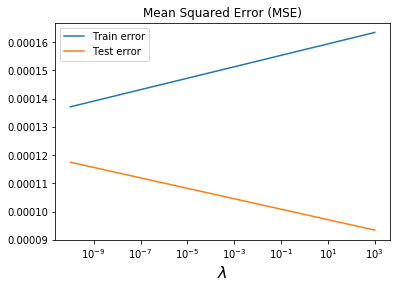

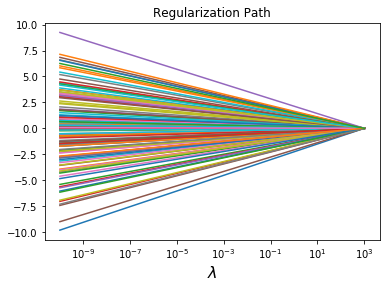

In [398]:
plot_train_test_errors(train_errors, test_errors, lambd_values)
plot_regularization_path(lambd_values, beta_values)

In [ ]:
r_squared

## Specify plotters for regressions

In [396]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()


In [397]:
def generate_data(m=100, n=20, sigma=5, density=0.2):
        "Generates data matrix X and observations Y."
        np.random.seed(1)
        beta_star = np.random.randn(n)
        idxs = np.random.choice(range(n), int((1-density)*n), replace=False)
        for idx in idxs:
            beta_star[idx] = 0
        X = np.random.randn(m,n)
        Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
        return X, Y, beta_star


## Set up and clean data [ 2]

In [ ]:
data_columns = list(data_in.columns)
data_copy = data_in.copy(deep = True)
data_copy = data_copy.rename( columns = {
    
    'date': 'date',
    'open':'price',
    #'Ticker':'ticker'
    
})
data_copy['ticker'] = "EURUSD"

In [ ]:
## Cast all relevant objects to floats

float_list = ['price','close']

for item in float_list:
    data_copy[item] = data_copy[item].astype('float64')

In [ ]:
## Cast all relevant objects to dates

float_list = ['date']
for item in float_list:
    data_copy[item] = pd.to_datetime(data_copy[item])

## Calculate output variables

In [ ]:
x_variables_actual = []
y_variables_actual = []
for item in window_range:
    for key,value in x_dic.items():
        #print("calculating indicators for: " + str(key))
        if value.type == "window":
            
            [data_copy,b] = value(data_copy,'price',item)
            x_variables_actual.append(b)
        elif value.type == "window_shift":
            for jtem in shift_range:
                [data_copy,b] = value(data_copy,'price',item,jtem)
                x_variables_actual.append(b)
        else:
            print("Functions specified incorrectly")
            break
            
for item in window_range:
    for key,value in y_dic.items():
        #print("calculating indicators for: " + str(key))
        if value.type == "window":
            
            [data_copy,b] = value(data_copy,'price',item)
            y_variables_actual.append(b)
        elif value.type == "window_shift":
            for jtem in shift_range:
                [data_copy,b] = value(data_copy,'price',item,jtem)
                y_variables_actual.append(b)
        else:
            print("Functions specified incorrectly")
            break

In [ ]:
data_copy.iloc[:10]

## Specify backtest algorithm

In [ ]:
## Define lists of variables we are interested in

sub_x_variable_actual_list = []
for x in window_range:
    string = "last_%s_momentum" % x
    sub_x_variable_actual_list.append(string)
    string = "last_%s_RSI" % x
    sub_x_variable_actual_list.append(string)
    for item in shift_range:
        string = "rolling_"+str(x)+"_avg_"+str(item)+"_period_pct_change"
        sub_x_variable_actual_list.append(string)

sub_all_var_list = []
sub_all_var_list = sub_x_variable_actual_list
sub_all_var_list.append('forward_7_opportunity')
dep_var = 'forward_7_opportunity'
## Generate output matrices


output_df = data_copy.copy(deep = True)
output_df = output_df[['date']]
output_df['lasso_R_squared'] = None
output_df['lasso_lambd_opt'] = None
output_df['lasso_beta_values'] = None


## iterate through items
for counter,day in enumerate(range(0,len(data_copy))):
    print("Calculating for: " + str(counter))
    if day > (max(window_range)+min_data_points):
        if round(day/10,1) == round(day/10,0): ## Takes too long to do each one, so run one in ten
            test_data = data_copy.iloc[:counter]
            [a,b,c] = conduct_lasso(test_data,dep_var)
            output_df.at[counter,'lasso_R_squared'] = a
            output_df.at[counter,'lasso_lambd_opt'] = b
            output_df.at[counter,'lasso_beta_values'] = c
            print("Completed for iteration: " + str(counter))
        
            
    else:
        print("Ignoring row")
        
        
        


In [ ]:
betas = output_df['lasso_beta_values'].dropna()
beta_lag = output_df['lasso_beta_values'].dropna().shift(1)

In [ ]:
difference = betas - beta_lag

In [ ]:
difference = (difference**2)**(0.5)

In [ ]:
difference = difference.apply(lambda x: sum(x)).dropna()

In [ ]:
difference = difference.rolling(20).mean()

In [ ]:
plt.plot(difference)

In [ ]:
#### Lasso

regression_data.reset_index(drop = True, inplace = True)
m = len(regression_data)
n = len(sub_x_variable_actual_list)
X = np.array(regression_data[sub_x_variable_actual_list])
Y = np.array(regression_data['forward_7_opportunity'])
X_train = X[:int(m/2),:]
Y_train = Y[:int(m/2)]
X_test = X[int(m/2):,:]
Y_test = Y[int(m/2):]

beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn_lasso(X_train, Y_train, beta, lambd)))
lambd_values = np.logspace(-2, 3, 50) ## Changing the lambda is equivalent to changing the t in order to observe different levels of regularisation
train_errors = []
test_errors = []
beta_values = []
counter = 0
for v in lambd_values:
    lambd.value = v
    problem.solve()
    test_error = mse_lasso(X_test, Y_test, beta)
    train_errors.append(mse_lasso(X_train, Y_train, beta))
    test_errors.append(test_error)
    beta_values.append(beta.value)


opt_lambda = lambd_values[test_errors.index(min(test_errors))]
opt_beta = beta_values[test_errors.index(min(test_errors))]
y_pred = X_test@opt_beta
avg_ss = sum(((Y_test - Y_test.mean())**2)**(0.5))
pred_ss = sum(((Y_test - y_pred)**2)**(0.5))
r_squared = 1- (pred_ss/avg_ss)
#plot_train_test_errors(train_errors, test_errors, lambd_values)
#plot_regularization_path(lambd_values, beta_values)

In [ ]:
new_df = pd.DataFrame(data = (y_pred,Y_test) ,index = None)

In [ ]:
opt_lambda

In [ ]:
#### Ridge

#regression_data = data_copy.dropna()
#regression_data.reset_index(drop = True, inplace = True)
m = len(regression_data)
n = len(sub_x_variable_actual_list)
X = np.array(regression_data[sub_x_variable_actual_list])
Y = np.array(regression_data['forward_7_opportunity'])
X_train = X[:int(m/2),:]
Y_train = Y[:int(m/2)]
X_test = X[int(m/2):,:]
Y_test = Y[int(m/2):]

beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn_ridge(X_train, Y_train, beta, lambd)))
lambd_values = np.logspace(-2, 3, 50) ## Changing the lambda is equivalent to changing the t in order to observe different levels of regularisation
train_errors = []
test_errors = []
beta_values = []
counter = 0
for v in lambd_values:
    lambd.value = v
    problem.solve()
    test_error = mse_ridge(X_test, Y_test, beta)
    train_errors.append(mse_ridge(X_train, Y_train, beta))
    test_errors.append(test_error)
    beta_values.append(beta.value)


opt_lambda = lambd_values[test_errors.index(min(test_errors))]
opt_beta = beta_values[test_errors.index(min(test_errors))]
y_pred = X_test@opt_beta
avg_ss = sum(((Y_test - Y_test.mean())**2)**(0.5))
pred_ss = sum(((Y_test - y_pred)**2)**(0.5))
r_squared = 1- (pred_ss/avg_ss)
#plot_train_test_errors(train_errors, test_errors, lambd_values)
#plot_regularization_path(lambd_values, beta_values)

In [ ]:
plot_train_test_errors(train_errors, test_errors, lambd_values)
plot_regularization_path(lambd_values, beta_values)

In [ ]:
#### elastic_net

#regression_data = data_copy.dropna()
#regression_data.reset_index(drop = True, inplace = True)
m = len(regression_data)
n = len(sub_x_variable_actual_list)
X = np.array(regression_data[sub_x_variable_actual_list])
Y = np.array(regression_data['forward_7_opportunity'])
X_train = X[:int(m/2),:]
Y_train = Y[:int(m/2)]
X_test = X[int(m/2):,:]
Y_test = Y[int(m/2):]

beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn_elastic_net(X_train, Y_train, beta, lambd)))
lambd_values = np.logspace(-2, 3, 50) ## Changing the lambda is equivalent to changing the t in order to observe different levels of regularisation
train_errors = []
test_errors = []
beta_values = []
counter = 0
for v in lambd_values:
    lambd.value = v
    problem.solve()
    test_error = mse_elastic_net(X_test, Y_test, beta)
    train_errors.append(mse_elastic_net(X_train, Y_train, beta))
    test_errors.append(test_error)
    beta_values.append(beta.value)


opt_lambda = lambd_values[test_errors.index(min(test_errors))]
opt_beta = beta_values[test_errors.index(min(test_errors))]
y_pred = X_test@opt_beta
avg_ss = sum(((Y_test - Y_test.mean())**2)**(0.5))
pred_ss = sum(((Y_test - y_pred)**2)**(0.5))
r_squared = 1- (pred_ss/avg_ss)
#plot_train_test_errors(train_errors, test_errors, lambd_values)
#plot_regularization_path(lambd_values, beta_values)

In [ ]:

###########################REDEFINE TO BE BASED OFF PREVIOUS INDICATORS

##Redefine x variables to choose only necessary ones
x_variables = ['short_23_momentum',                                     #### When positive
               'last_14_RSI',                                          #### When above a certain level
               'rolling_7_day_price_avg_difference',                   #### When positive / negative
               
               'price']                                                #### when above or below


### Add in moving average buy status and p value
data_copy = is_positive_signal(data_copy,'rolling_21_day_price_avg_difference',1,60,1.6)
### Add in short momentum buy status and p value
data_copy =  is_positive_signal(data_copy,'short_23_momentum',1,60,1.6)
### Add in RSI buy status and p value
data_copy = upper_lower_bound_signal(data_copy,'last_14_RSI',0.7,0.3,1,60,1.6)
### Add in price differential and p value
data_copy = non_normal_and_negative_signal(data_copy,'price',7,60,1.6)

### Graph rider

In [ ]:
new_df = data_copy.copy(deep = True)
data1 = new_df['price']
data2 = data_copy['status_price'].apply(lambda x: 1 if x == "Buy" else (-1 if x == "Sell" else 0))
new_df['data_buy'] = data_copy['status_price'].apply(lambda x: 1 if x == "Buy" else None)
new_df['data_buy'] = new_df['data_buy']*new_df['price']
new_df['data_sell'] = data_copy['status_price'].apply(lambda x: 1 if x == "Sell" else None)
new_df['data_sell'] = new_df['data_sell']*new_df['price']
data2 = new_df['data_buy']
data3 = new_df['data_sell']#
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.scatter(new_df['date'], data2, c='green')
ax1.scatter(new_df['date'], data3, c='red')
ax1.plot(new_df['date'],data1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(new_df['date'], new_df['previous_7_pct_change'], color='purple')
ax2.tick_params(axis='y', labelcolor='purple')



plt.show()


In [ ]:
new_df = data_copy.copy(deep = True)
data1 = new_df['price']
data2 = data_copy['status_last_14_RSI'].apply(lambda x: 1 if x == "Buy" else (-1 if x == "Sell" else 0))
new_df['data_buy'] = data_copy['status_last_14_RSI'].apply(lambda x: 1 if x == "Buy" else None)
new_df['data_buy'] = new_df['data_buy']*new_df['price']
new_df['data_sell'] = data_copy['status_last_14_RSI'].apply(lambda x: 1 if x == "Sell" else None)
new_df['data_sell'] = new_df['data_sell']*new_df['price']
data2 = new_df['data_buy']
data3 = new_df['data_sell']#
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.scatter(new_df['date'], data2, c='green')
ax1.scatter(new_df['date'], data3, c='red')
ax1.plot(new_df['date'],data1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(new_df['date'], new_df['last_14_RSI'], color='purple')
ax2.tick_params(axis='y', labelcolor='purple')



plt.show()


In [ ]:
new_df = data_copy.copy(deep = True)
data1 = new_df['price']
data2 = data_copy['status_short_23_momentum'].apply(lambda x: 1 if x == "Buy" else (-1 if x == "Sell" else 0))
new_df['data_buy'] = data_copy['status_short_23_momentum'].apply(lambda x: 1 if x == "Buy" else None)
new_df['data_buy'] = new_df['data_buy']*new_df['price']
new_df['data_sell'] = data_copy['status_short_23_momentum'].apply(lambda x: 1 if x == "Sell" else None)
new_df['data_sell'] = new_df['data_sell']*new_df['price']
data2 = new_df['data_buy']
data3 = new_df['data_sell']#
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.scatter(new_df['date'], data2, c='green')
ax1.scatter(new_df['date'], data3, c='red')
ax1.plot(new_df['date'],data1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(new_df['date'], new_df['short_23_momentum'], color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.show()


In [ ]:
new_df = data_copy.copy(deep = True)
data1 = new_df['price']
#data2 = data_copy['status_rolling_21_day_price_avg_difference'].apply(lambda x: 1 if x == "Buy" else (-1 if x == "Sell" else 0))
new_df['data_buy'] = data_copy['status_rolling_21_day_price_avg_difference'].apply(lambda x: 1 if x == "Buy" else None)
new_df['data_buy'] = new_df['data_buy']*new_df['price']
new_df['data_sell'] = data_copy['status_rolling_21_day_price_avg_difference'].apply(lambda x: 1 if x == "Sell" else None)
new_df['data_sell'] = new_df['data_sell']*new_df['price']
data2 = new_df['data_buy']
data3 = new_df['data_sell']#
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.scatter(new_df['date'], data2, c='green')
plt.scatter(new_df['date'], data3, c='red')
plt.plot(new_df['date'],data1)
plt.plot(new_df['date'],new_df['price'].rolling(21).mean(), c = "blue")


plt.show()
